In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from sklearn.metrics import classification_report,confusion_matrix

## loading dataset

In [2]:
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'

In [3]:
classes = sorted(os.listdir(train_dir))
print(classes)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [7]:
img_height = 224
img_width = 224

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    validation_split=0.20,
    horizontal_flip = True
    )

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20, 
                                                    subset = 'training',
                                                    target_size = (img_height, img_width))




Found 3803 images belonging to 12 classes.


In [11]:
validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                        batch_size = 20,
                                                         subset='validation',
                                                        target_size = (img_height, img_width))

Found 947 images belonging to 12 classes.


## VGG


In [12]:
from keras.applications.vgg16 import preprocess_input,decode_predictions,VGG16
base_model = VGG16( input_shape = (img_height,img_width, 3), 
include_top = False, 
weights = 'imagenet')

2022-03-08 15:21:16.206959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 15:21:16.308722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 15:21:16.309501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 15:21:16.310666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


##### 18 layers 


In [13]:
for layer in base_model.layers[:15]:
    layer.trainable = False

In [14]:
x = base_model.output
x = layers.Flatten()(x)
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x) 
x = Dense(256, activation='relu')(x)
x = Dense(12, activation='softmax')(x)
vgg_model = models.Model(inputs=base_model.input, outputs=x)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('vgg.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [16]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
vgg_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

vgghistory = vgg_model.fit_generator(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10, 
    shuffle=True, 
    callbacks =[checkpoint],
    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-08 15:21:20.323698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-08 15:21:22.595899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


191/191 [==============================] - 157s 778ms/step - loss: 2.0478 - accuracy: 0.2932 - val_loss: 1.4419 - val_accuracy: 0.5037

Epoch 00001: val_accuracy improved from -inf to 0.50370, saving model to vgg.h5
Epoch 2/10
191/191 [==============================] - 106s 556ms/step - loss: 1.3512 - accuracy: 0.5241 - val_loss: 0.9927 - val_accuracy: 0.6906

Epoch 00002: val_accuracy improved from 0.50370 to 0.69060, saving model to vgg.h5
Epoch 3/10
191/191 [==============================] - 106s 556ms/step - loss: 1.0172 - accuracy: 0.6400 - val_loss: 0.9045 - val_accuracy: 0.6811

Epoch 00003: val_accuracy did not improve from 0.69060
Epoch 4/10
191/191 [==============================] - 105s 552ms/step - loss: 0.8506 - accuracy: 0.7089 - val_loss: 0.7440 - val_accuracy: 0.7318

Epoch 00004: val_accuracy improved from 0.69060 to 0.73178, saving model to vgg.h5
Epoch 5/10
191/191 [==============================] - 105s 552ms/step - loss: 0.7256 - accuracy: 0.7436 - val_loss: 0.7173

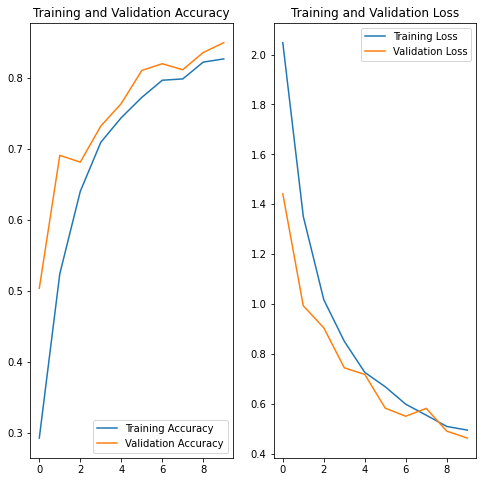

In [17]:
acc = vgghistory.history['accuracy']
val_acc = vgghistory.history['val_accuracy']

loss = vgghistory.history['loss']
val_loss = vgghistory.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
y_pred1 = vgg_model.predict(validation_generator)
y_pred1 = np.argmax(y_pred1, axis=1)
y_pred1.sort()

In [20]:
cm1 = confusion_matrix(validation_generator.classes, y_pred1)

In [21]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


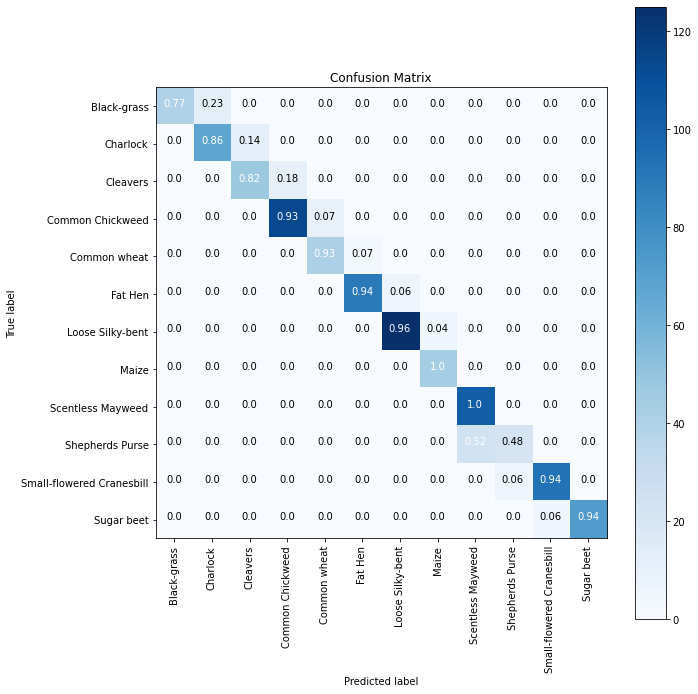

In [22]:
plot_confusion_matrix(cm1, classes, title='Confusion Matrix')

In [23]:
print(classification_report(validation_generator.classes, y_pred1,target_names = classes))

                           precision    recall  f1-score   support

              Black-grass       1.00      0.77      0.87        52
                 Charlock       0.85      0.86      0.85        78
                 Cleavers       0.81      0.82      0.82        57
         Common Chickweed       0.92      0.93      0.92       122
             Common wheat       0.82      0.93      0.87        44
                  Fat Hen       0.97      0.94      0.95        95
         Loose Silky-bent       0.95      0.96      0.96       130
                    Maize       0.90      1.00      0.95        44
        Scentless Mayweed       0.81      1.00      0.90       103
          Shepherds Purse       0.79      0.48      0.59        46
Small-flowered Cranesbill       0.95      0.94      0.94        99
               Sugar beet       1.00      0.94      0.97        77

                 accuracy                           0.90       947
                macro avg       0.90      0.88      0.88    

## RESNET

In [24]:

from tensorflow.keras.applications.resnet50 import ResNet50
base_model1 = ResNet50( input_shape = (img_height,img_width, 3),include_top = False, weights = 'imagenet')

94781440/94765736 [==============================] - 0s 0us/step


#### 174 layers

In [48]:
for layer in base_model1.layers[:15]:
    layer.trainable = False

In [26]:
x1 = base_model1.output
x1 = layers.Flatten()(x1)
x1 = Dense(512, activation='relu')(x1)
x1 = layers.Dropout(0.5)(x1) 
x1 = Dense(256, activation='relu')(x1)

x1 = Dense(12, activation='softmax')(x1)
resnet_model = models.Model(inputs=base_model1.input, outputs=x1)


In [27]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('resnet.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [28]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
resnet_model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])


In [29]:
resnethistory = resnet_model.fit_generator(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10, 
    shuffle=True, 
    callbacks = [checkpoint],
    verbose=1)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
191/191 [==============================] - 116s 582ms/step - loss: 2.0501 - accuracy: 0.3815 - val_loss: 4.3111 - val_accuracy: 0.1373

Epoch 00001: val_accuracy improved from -inf to 0.13728, saving model to resnet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
191/191 [==============================] - 110s 577ms/step - loss: 0.8525 - accuracy: 0.7229 - val_loss: 5.0607 - val_accuracy: 0.1373

Epoch 00002: val_accuracy did not improve from 0.13728
Epoch 3/10
191/191 [==============================] - 110s 577ms/step - loss: 0.5639 - accuracy: 0.8146 - val_loss: 6.2798 - val_accuracy: 0.1373

Epoch 00003: val_accuracy did not improve from 0.13728
Epoch 4/10
191/191 [==============================] - 110s 578ms/step - loss: 0.4968 - accuracy: 0.8393 - val_loss: 5.2687 - val_accuracy: 0.1415

Epoch 00004: val_accuracy improved from 0.13728 to 0.14150, saving model to resnet.h5
Epoch 5/10
191/191 [==============================] - 111s 583ms/step - loss: 0.3917 - accuracy: 0.8662 - val_loss: 3.0050 - val_accuracy: 0.2967

Epoch 00005: val_accuracy improved from 0.14150 to 0.29673, saving model to resnet.h5
Epoch 6/10
191/191 [==============================] - 112s 587ms/step - loss: 0.3527 - accuracy: 0.8804 - val_loss: 0.7107 - val_a

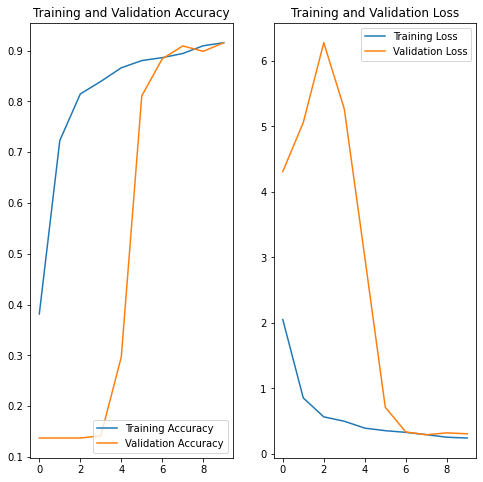

In [30]:
acc = resnethistory.history['accuracy']
val_acc = resnethistory.history['val_accuracy']

loss = resnethistory.history['loss']
val_loss = resnethistory.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
y_pred2 = resnet_model.predict(validation_generator)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2.sort()

In [32]:
cm2 = confusion_matrix(validation_generator.classes, y_pred2)

Normalized confusion matrix


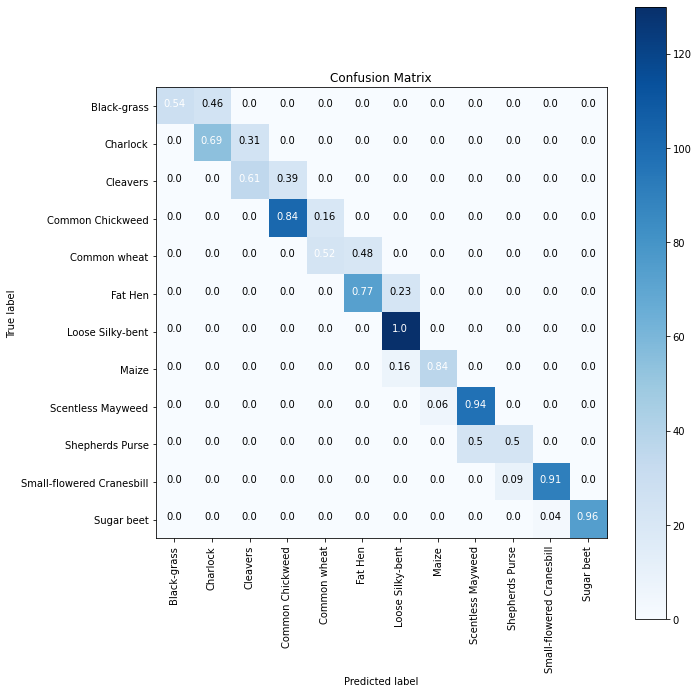

In [33]:
plot_confusion_matrix(cm2, classes, title='Confusion Matrix')

In [34]:
print(classification_report(validation_generator.classes, y_pred2,target_names = classes))

                           precision    recall  f1-score   support

              Black-grass       1.00      0.54      0.70        52
                 Charlock       0.69      0.69      0.69        78
                 Cleavers       0.59      0.61      0.60        57
         Common Chickweed       0.82      0.84      0.83       122
             Common wheat       0.53      0.52      0.53        44
                  Fat Hen       0.78      0.77      0.77        95
         Loose Silky-bent       0.82      1.00      0.90       130
                    Maize       0.86      0.84      0.85        44
        Scentless Mayweed       0.81      0.94      0.87       103
          Shepherds Purse       0.72      0.50      0.59        46
Small-flowered Cranesbill       0.97      0.91      0.94        99
               Sugar beet       1.00      0.96      0.98        77

                 accuracy                           0.81       947
                macro avg       0.80      0.76      0.77    

## Inception

In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(input_shape = (img_height,img_width, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


#### 310 layers

In [37]:
for layer in base_model2.layers[:15]:
    layer.trainable = False

In [38]:
x2 = base_model2.output
x2 = layers.Flatten()(x2)
x2 = Dense(512, activation='relu')(x2)
x2 = layers.Dropout(0.5)(x2) 
x2 = Dense(256, activation='relu')(x2)
x2 = Dense(12, activation='softmax')(x2) 
inc_model = models.Model(inputs=base_model2.input, outputs=x2)

In [39]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./inc.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [40]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
inc_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])



In [41]:
inchistory = inc_model.fit_generator(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10, 
    shuffle=True, 
    callbacks = [checkpoint],
    verbose=1)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
191/191 [==============================] - 118s 582ms/step - loss: 2.1462 - accuracy: 0.2958 - val_loss: 1.1566 - val_accuracy: 0.6389

Epoch 00001: val_accuracy improved from -inf to 0.63886, saving model to ./inc.h5
Epoch 2/10
191/191 [==============================] - 110s 574ms/step - loss: 1.0292 - accuracy: 0.6558 - val_loss: 0.5387 - val_accuracy: 0.8057

Epoch 00002: val_accuracy improved from 0.63886 to 0.80570, saving model to ./inc.h5
Epoch 3/10
191/191 [==============================] - 110s 574ms/step - loss: 0.6086 - accuracy: 0.8017 - val_loss: 0.4408 - val_accuracy: 0.8585

Epoch 00003: val_accuracy improved from 0.80570 to 0.85850, saving model to ./inc.h5
Epoch 4/10
191/191 [==============================] - 109s 573ms/step - loss: 0.4776 - accuracy: 0.8370 - val_loss: 0.3446 - val_accuracy: 0.9007

Epoch 00004: val_accuracy improved from 0.85850 to 0.90074, saving model to ./inc.h5
Epoch 5/10
191/191 [==============================] - 109s 573ms/step - los

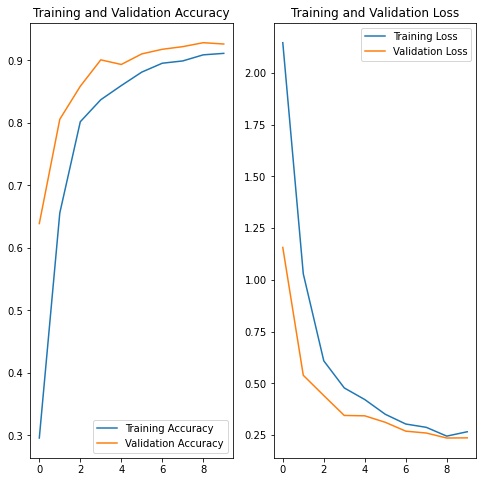

In [42]:
acc = inchistory.history['accuracy']
val_acc = inchistory.history['val_accuracy']

loss = inchistory.history['loss']
val_loss = inchistory.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [43]:
y_pred3 = inc_model.predict(validation_generator)
y_pred3 = np.argmax(y_pred3, axis=1)
y_pred3.sort()

In [44]:
cm3 = confusion_matrix(validation_generator.classes, y_pred3)

Normalized confusion matrix


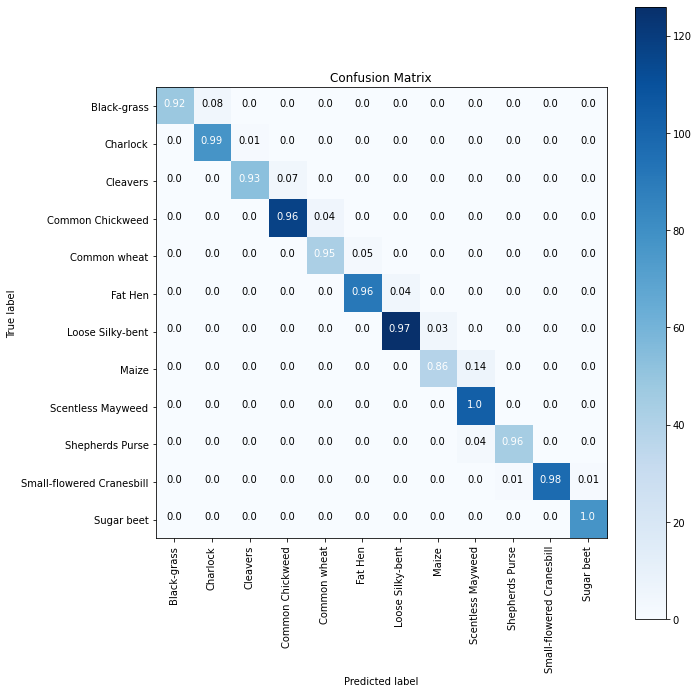

In [45]:
plot_confusion_matrix(cm3, classes, title='Confusion Matrix')

In [46]:
print(classification_report(validation_generator.classes, y_pred3,target_names = classes))

                           precision    recall  f1-score   support

              Black-grass       1.00      0.92      0.96        52
                 Charlock       0.95      0.99      0.97        78
                 Cleavers       0.98      0.93      0.95        57
         Common Chickweed       0.97      0.96      0.96       122
             Common wheat       0.89      0.95      0.92        44
                  Fat Hen       0.98      0.96      0.97        95
         Loose Silky-bent       0.97      0.97      0.97       130
                    Maize       0.90      0.86      0.88        44
        Scentless Mayweed       0.93      1.00      0.96       103
          Shepherds Purse       0.98      0.96      0.97        46
Small-flowered Cranesbill       1.00      0.98      0.99        99
               Sugar beet       0.99      1.00      0.99        77

                 accuracy                           0.96       947
                macro avg       0.96      0.96      0.96    